1. My take at creating a Risk Scorer model is, creating a model really good at predicting whether if study fails, i.e reducing Type-II error, meaning reducing FN (False Negative) error, or in other words increasing recall since {recall = TP/(TP+FN)}.
So, the model will be able to predict failed studies with 100% accuracy.
2. To achieve this we will be using AUC-ROC curve to evaluate threshold value, which will hep us classify all the failed trials with 100% accuracy.
3. We have 12 different combinations, 4 types of dataframes and 3 different models. I want to find out how far we can increase recall score without using threshold values, by optimizing our models for higher recall score. 
3. We will take best combination and derive our final Risk Scorer model.

In [399]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import pickle
import warnings
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

global model_name, model, dataframe_type, X_train, X_test, y_train, y_test

output_feature = 'Results'

In [400]:
dataframes = pd.read_pickle('../../data/dataframes.pkl')

In [401]:
models = {
    'random_forest_classifier' : RandomForestClassifier(),
    'ada_boost_classifier' : AdaBoostClassifier(),
    'XGBoost_classifier' : XGBClassifier(),
}

In [402]:
model_params = {}

In [403]:
def objective(trial):

    if model_name == 'ada_boost_classifier':
        params = {
            'n_estimators' : trial.suggest_int('n_estimators', 50, 200),
            'learning_rate' : trial.suggest_float('learning_rate', 0, 1000),
            'algorithm' : trial.suggest_categorical('algorithm', ['SAMME']),
        }
    elif model_name == 'random_forest_classifier':
        params = {
            'n_estimators' : trial.suggest_int('n_estimators', 5, 200),
            'criterion'    : trial.suggest_categorical('criterion', ['log_loss', 'entropy', 'gini']),
            'max_depth'    : trial.suggest_int('max_depth', 1, 100),
            'min_samples_split' : trial.suggest_int('min_samples_split', 2, 100),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 100),
            'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        }
    elif model_name == 'XGBoost_classifier':
        params = {
            "silent": 1,
            "objective": "binary:logistic",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        }
        if params["booster"] == "gbtree" or params["booster"] == "dart":
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            params["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
            params["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
            params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        if params["booster"] == "dart":
            params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
            params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # mod = model(**params)
    # mod.fit(X_train, y_train)
    if model_name == 'ada_boost_classifier':
        mod = AdaBoostClassifier(**params)
        mod.fit(X_train, y_train)
    elif model_name == 'random_forest_classifier':
        mod = RandomForestClassifier(**params)
        mod.fit(X_train, y_train)
    elif model_name == 'XGBoost_classifier':
        mod = XGBClassifier(**params)
        mod.fit(X_train, y_train)

    y_pred = mod.predict(X_test)
    # f1_scr = f1_score(y_pred=y_pred, y_true=y_test)
    # pre_score = precision_score(y_pred=y_pred, y_true=y_test)
    recall_scr = recall_score(y_pred=y_pred, y_true=y_test)

    return recall_scr

In [404]:
for df_type, df in zip(dataframes.keys(), dataframes.values()):

    dataframe_type = df_type

    for name, mod in zip(models.keys(), models.values()):

        model_name = name
        model = mod
        # print('{} : {}'.format(dataframe_type, model_name))

        X = df.drop(output_feature, axis=1)
        y = df['Results']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=10)

        trial = study.best_trials[0]
        key = model_name + '-' + dataframe_type
        model_params[key] = trial.params.items()

[I 2024-11-19 06:56:05,975] A new study created in memory with name: no-name-1057eb0e-164e-4443-adb5-7c0dad4ea33a
[I 2024-11-19 06:56:08,144] Trial 0 finished with value: 0.9535415079969536 and parameters: {'n_estimators': 183, 'criterion': 'entropy', 'max_depth': 97, 'min_samples_split': 10, 'min_samples_leaf': 80, 'max_features': 'log2'}. Best is trial 0 with value: 0.9535415079969536.
[I 2024-11-19 06:56:09,299] Trial 1 finished with value: 0.948971820258949 and parameters: {'n_estimators': 66, 'criterion': 'entropy', 'max_depth': 99, 'min_samples_split': 67, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9535415079969536.
[I 2024-11-19 06:56:11,467] Trial 2 finished with value: 0.9421172886519421 and parameters: {'n_estimators': 158, 'criterion': 'log_loss', 'max_depth': 94, 'min_samples_split': 69, 'min_samples_leaf': 32, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9535415079969536.
[I 2024-11-19 06:56:14,240] Trial 3 finished with value:

In [405]:
model_params

{'random_forest_classifier-feat_imp_with_out': dict_items([('n_estimators', 183), ('criterion', 'entropy'), ('max_depth', 97), ('min_samples_split', 10), ('min_samples_leaf', 80), ('max_features', 'log2')]),
 'ada_boost_classifier-feat_imp_with_out': dict_items([('n_estimators', 167), ('learning_rate', 683.6515572409392), ('algorithm', 'SAMME')]),
 'XGBoost_classifier-feat_imp_with_out': dict_items([('booster', 'dart'), ('lambda', 3.5952359577078207e-06), ('alpha', 1.3807284207898895e-08), ('max_depth', 8), ('eta', 3.588893666120912e-07), ('gamma', 0.0027036808738728543), ('grow_policy', 'depthwise'), ('sample_type', 'uniform'), ('normalize_type', 'tree'), ('rate_drop', 6.4285705695131995e-06), ('skip_drop', 1.796292670776078e-06)]),
 'random_forest_classifier-feat_imp_without_out': dict_items([('n_estimators', 28), ('criterion', 'entropy'), ('max_depth', 5), ('min_samples_split', 9), ('min_samples_leaf', 25), ('max_features', 'sqrt')]),
 'ada_boost_classifier-feat_imp_without_out': di

In [406]:
model_comp = {
    'model_name' : list(),
    'dataframe_type' : list(),
    'metrics' : list(),
    'score' : list()
}

In [407]:
for model_df_type, params in zip(model_params.keys(), model_params.values()):

    model_name, df_type = model_df_type.split('-')
    parameters = dict(params)
    if model_name == 'random_forest_classifier':
        model = RandomForestClassifier(**parameters)
    elif model_name == 'ada_boost_classifier':
        model = AdaBoostClassifier(**parameters)
    elif model_name == 'XGBoost_classifier':
        model = XGBClassifier(**parameters)

    df = dataframes[df_type]
    X = df.drop(output_feature, axis=1)
    y = df[output_feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision_scr = precision_score(y_true=y_test, y_pred=y_pred)
    recall_scr = recall_score(y_true=y_test, y_pred=y_pred)
    f1_scr = f1_score(y_true=y_test, y_pred=y_pred)

    model_comp['model_name'].append(model_name)
    model_comp['dataframe_type'].append(df_type)
    model_comp['metrics'].append('precision_score')
    model_comp['score'].append(precision_scr)

    model_comp['model_name'].append(model_name)
    model_comp['dataframe_type'].append(df_type)
    model_comp['metrics'].append('recall_score')
    model_comp['score'].append(recall_scr)
    
    model_comp['model_name'].append(model_name)
    model_comp['dataframe_type'].append(df_type)
    model_comp['metrics'].append('F1_score')
    model_comp['score'].append(f1_scr)
    

In [408]:
model_comp_df = pd.DataFrame(data=model_comp)

model_comp_df.head()

,model_name,dataframe_type,metrics,score
0,random_forest_classifier,feat_imp_with_out,precision_score,0.810846
1,random_forest_classifier,feat_imp_with_out,recall_score,0.956588
2,random_forest_classifier,feat_imp_with_out,F1_score,0.877708
3,ada_boost_classifier,feat_imp_with_out,precision_score,0.762485
4,ada_boost_classifier,feat_imp_with_out,recall_score,1.000000


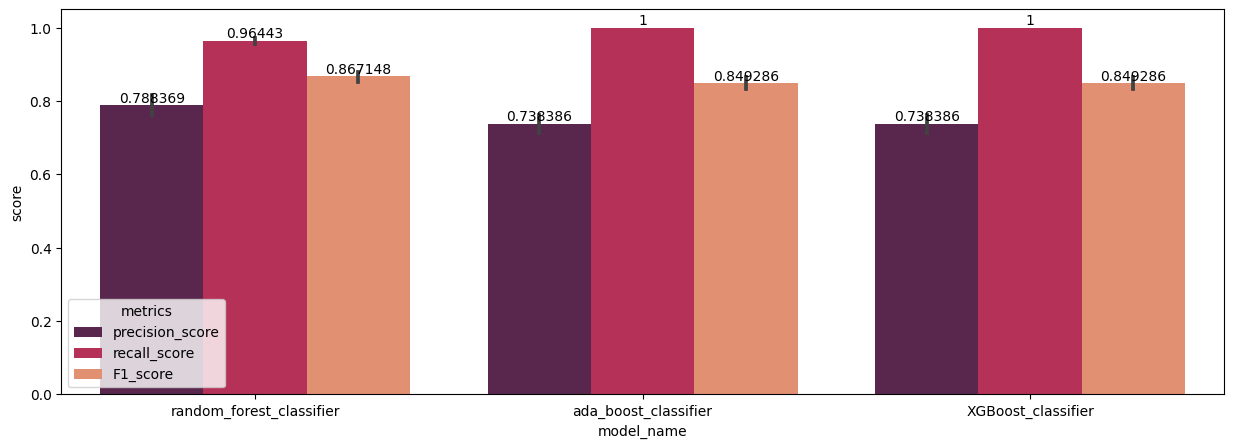

In [409]:
plt.figure(figsize=(15, 5))

ax = sns.barplot(data=model_comp_df, x='model_name', y='score', hue='metrics', palette='rocket')

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

Comparing model wise performance considering metrices we can see that we are able to optimize AdaBoost and XGBoost models for highest recall score. That is Recall_score = 1 and FN (False Negative) error = "Zero". Which is exactly what we wanted for our risk scorer model. So, when our model predicts that a certain study fails we can be sure that it the model is predicting it with 100% accuracy. In other words our model has become really good at classifying studies which fail. 

In [410]:
model_comp_df[(model_comp_df['metrics'] == 'recall_score') & ((model_comp_df['model_name'] == 'random_forest_classifier') | (model_comp_df['model_name'] == 'XGBoost_classifier'))].sort_values('score', ascending=False).head(4)

,model_name,dataframe_type,metrics,score
7,XGBoost_classifier,feat_imp_with_out,recall_score,1.0
16,XGBoost_classifier,feat_imp_without_out,recall_score,1.0
25,XGBoost_classifier,chi2_with_out,recall_score,1.0
34,XGBoost_classifier,chi2_without_out,recall_score,1.0


## **Answers**

### **Task 1 : Consume this data and build a model to quantify the risk of a trial. The generated value should reflect how likely the trial is to fail**

**Risk Scorer Model**

Best combination seems to be :
    <p>Model : Random Forest Classifier</p>
    <p>Feature selection technique : Feature Importance</p>
    <p>DataFrame Type : With Outliers</p>

To solve this instead of predicting classes, we will predict probability of the class 0. Which will indicate that how likely is that trail to fail.

In [411]:
best_param = dict(model_params['random_forest_classifier-feat_imp_with_out'])
model = RandomForestClassifier(**best_param)

df = dataframes['feat_imp_with_out']

X = df.drop(output_feature, axis=1)
y = df[output_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

confusion_matrix(y_pred=y_pred, y_true=y_test)

array([[ 112,  297],
       [  57, 1256]], dtype=int64)

We can see that our model is classifing all the failed studies with 100% accuracy. since, FN = 0. To get the value signifying how likely the trail is to fail we will use y_prob values.

In [412]:
model.classes_

array([0, 1], dtype=int64)

In [413]:
y_prob[:, :1]

array([[0.32323819],
       [0.10781792],
       [0.27201922],
       ...,
       [0.32994883],
       [0.42715397],
       [0.31164831]])

Above values indicate the chances of trial failing.

Since we were able to optimize our model to produce recall score = 1. we did not need the help of AUC-ROC. Still we can use it to preserve the recall score = 1 and reduce the False Positive values which we saw in confusion matrix above. There has to be a threshold value which can give us highest recall score and minimum False Positive values. As of now i am choosing not to do it.